# Example showing how to compute the offset calibration using the cross-talk effect in LinoSPAD2.

TODO WRITE TEXT, Add comments to 2 functions added to cross_talk (docs etc.)
Import functions and set absolute path to .dat files


In [1]:
import matplotlib.pyplot as plt
from daplis.functions import cross_talk, fits
path = r"C:\Users\Ondra\Desktop\dezertacka\data\offset_w_LED"

Now, calculate timestamp differences for the pixels of interest. The result is saved in the 'cross_talk_data' folder at the same location where '.dat' data files are located.

In [ ]:
#Dont forget to set every parameter correctly here based on your data!
cross_talk.cross_talk_offset_collect(
    path,
    rewrite=True,
    daughterboard_number="B7d",
    motherboard_number="#28",
    firmware_version="2212s",
    timestamps=100,
)



> > > Collecting cross-talk data < < <

Creating pixel pairs from 0 to 255


Calculating timestamp differences between all pixels

! ! ! Feather file with timestamps differences already exists and will be rewritten ! ! !


! ! ! Deleting the file in 5 ! ! !


! ! ! Deleting the file in 4 ! ! !


! ! ! Deleting the file in 3 ! ! !


! ! ! Deleting the file in 2 ! ! !


! ! ! Deleting the file in 1 ! ! !




> > > Timestamp differences are saved as0000072934-0000073033_pixels_130-131.feather in C:\Users\Ondra\Desktop\dezertacka\data\offset_w_LED\cross_talk_data < < <


After collecting the timestamp differences, we can plot the CT peaks and offset them to zero and visualise them.

In [3]:
#TODO  starting from pixel 131, several pixels have 0 timestamps, so they would poduce errors, inside cross_talk_offset_plot for these empty pixels mu, sig = 0, 1
correct_pix_address = False
print("Creating pixel pairs from 0 to 255")
pix_pairs = [[i, i+1] for i in range(255)]
if correct_pix_address:
    for pi, pixels in enumerate(pix_pairs):
        for i, pixel in enumerate(pixels):
            if pixel > 127:
                pixels[i] = 255 - pixel
            else:
                pixels[i] = pixel + 128
        pix_pairs[pi] = pixels
# Collecting sensor population
mus = []
multiplier = 10
for pixels in pix_pairs:
    #This explicitly sets all dead pixels to 0 mu
    mu, sigma = cross_talk.cross_talk_offset_plot(
    path,
    pixels,
    show_plot=False, multiplier = multiplier
    )
    mus.append(mu)


Creating pixel pairs from 0 to 255


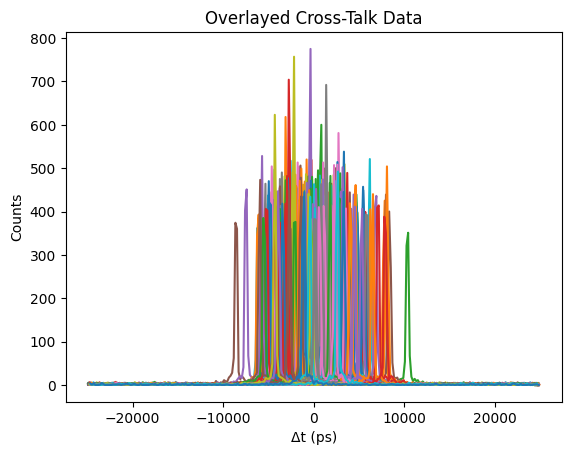

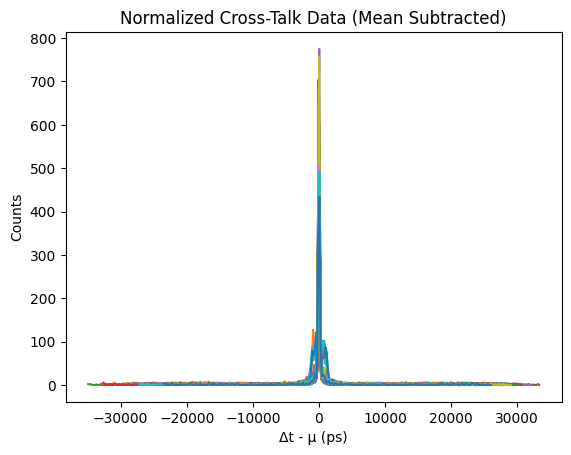

In [4]:
# print([float(mu) for mu in mus])
for pixels in pix_pairs:

    cross_talk.plot_overlayed_data(path, pixels,show_plot=False, multiplier = multiplier)
plt.show()
for idx, pixels in enumerate(pix_pairs):
    cross_talk.plot_normalized_data(path, pixels, mus[idx], multiplier = multiplier)
plt.show()



# Solving the Offset Equations using a Linear Matrix Equation

## Formulation of the System

We have the system of equations:

```math
(t_i + d_i) - (t_j + d_j) = d_i - d_j = 	off_{ij}, \quad i \in [0,254]. \quad j \in [1,255].
```
Here the t_i, t_j are timestamps, which for CT are the same as delta_t = 0. The equations simplify to known offset being equal to difference between the delays in propagation.

```math
\sum_{k=0}^{255} d_k = 0.
```

Rewriting this in matrix form:

```math
Ax = b
```

where:
- \( A \) is a bidiagonal matrix,
- \( x \) represents the unknown delays values,
- \( b \) is the vector of given offsets.

## Bidiagonal Matrix Structure

The system can be represented in matrix form as:
\begin{equation}
A = 
\begin{bmatrix}
1 & -1 & 0 & 0 & \cdots & 0 \\
0 & 1 & -1 & 0 & \cdots & 0 \\
0 & 0 & 1 & -1 & \cdots & 0 \\
\vdots & \vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & 0 & \cdots & -1 \\
1 & 1 & 1 & 1 & \cdots & 1
\end{bmatrix}
\end{equation}

```


In [92]:
import numpy as np
import copy
from scipy.optimize import lsq_linear

offsets = copy.copy(mus)

#append 0 to mus which will be for the sum = 0
offsets.append(0)
A0 = np.eye(len(offsets))
A1 = -1*np.eye(len(offsets),k=1)
A = A0 + A1

res = lsq_linear(A, offsets)
# print(res.x, res.cost)
ppd = res.x #per pixel delay
np.save('offset_calib_data.npy', ppd)
appd = np.abs(ppd) #absolute per pixel delay as the sign is just the position fo the peak relative to origin

#Calculate the error of delays as solution
deviations = offsets - A @ ppd  # Difference between actual and predicted values
std_dev = np.std(deviations, ddof=1)  # Use ddof=1 for an unbiased estimate

np.save('offset_calib_std.npy', std_dev)


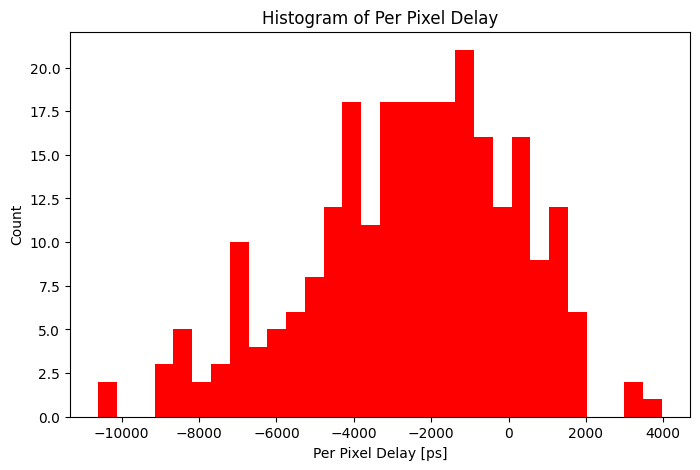

In [96]:
#Plot of all delays
import matplotlib.pyplot as plt
delays = np.load("offset_calib_data.npy")
plt.figure(figsize=(8, 5))
plt.hist(delays, bins=30, color="red")
plt.title("Histogram of Per Pixel Delay")
plt.xlabel("Per Pixel Delay [ps]")
plt.ylabel("Count")
plt.savefig("ppdelay.png")
plt.show()

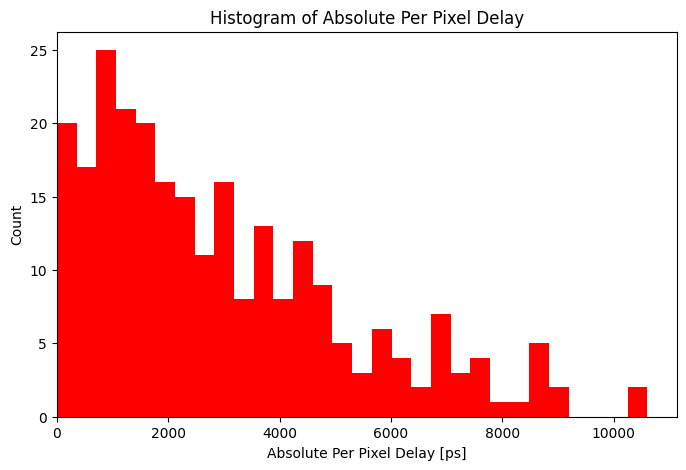

In [97]:
#plot of absolute delays
import numpy as np
import matplotlib.pyplot as plt
delays = np.load("offset_calib_data.npy")
plt.figure(figsize=(8, 5))
plt.hist(np.abs(delays), bins=30, color="red")
plt.title("Histogram of Absolute Per Pixel Delay")
plt.xlabel("Absolute Per Pixel Delay [ps]")
plt.ylabel("Count")
plt.xlim(0)
plt.savefig("appd.png")
plt.show()

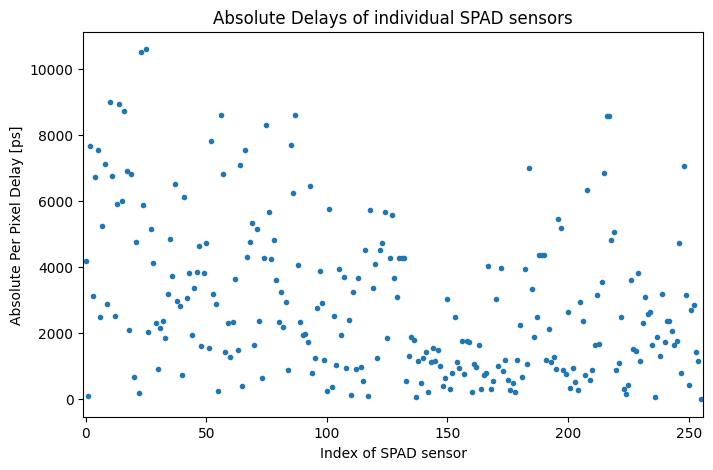

In [98]:
#plot of delays as function of pixel index
import numpy as np
import matplotlib.pyplot as plt
delays = np.load("offset_calib_data.npy")
std = np.load("offset_calib_std.npy")
print

plt.figure(figsize=(8, 5))
plt.errorbar(np.arange(np.max(delays.shape)), np.abs(delays), std, linestyle='None', marker='.')
plt.title("Absolute Delays of individual SPAD sensors")
plt.xlabel("Index of SPAD sensor")
plt.ylabel("Absolute Per Pixel Delay [ps]")
plt.xlim(-1,256)
plt.savefig("delays.png")
plt.show()